# 09.26.2023

# Требования задачи
Задача заключается в определении области или областей поражённых пневмонией на снимках лёгких. Снимки представлены в виде DICOM файла, который является стандартом для записи снимков МРТ.

# Шаги для выполнения задачи
**Инструкция:** https://medium.com/nuances-of-programming/%D1%80%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE-%D0%BF%D0%BE-%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%BC%D1%83-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B4%D0%BB%D1%8F-%D0%BD%D0%BE%D0%B2%D0%B8%D1%87%D0%BA%D0%BE%D0%B2-172547492990

**Основа кода:** https://www.kaggle.com/code/tomasfilip/r-cnn-pneumonia-detection#Pneumonia-Detection

**1. Работа с данными и их визуализация**

**2. Выбор алгоритма машинного обучения**
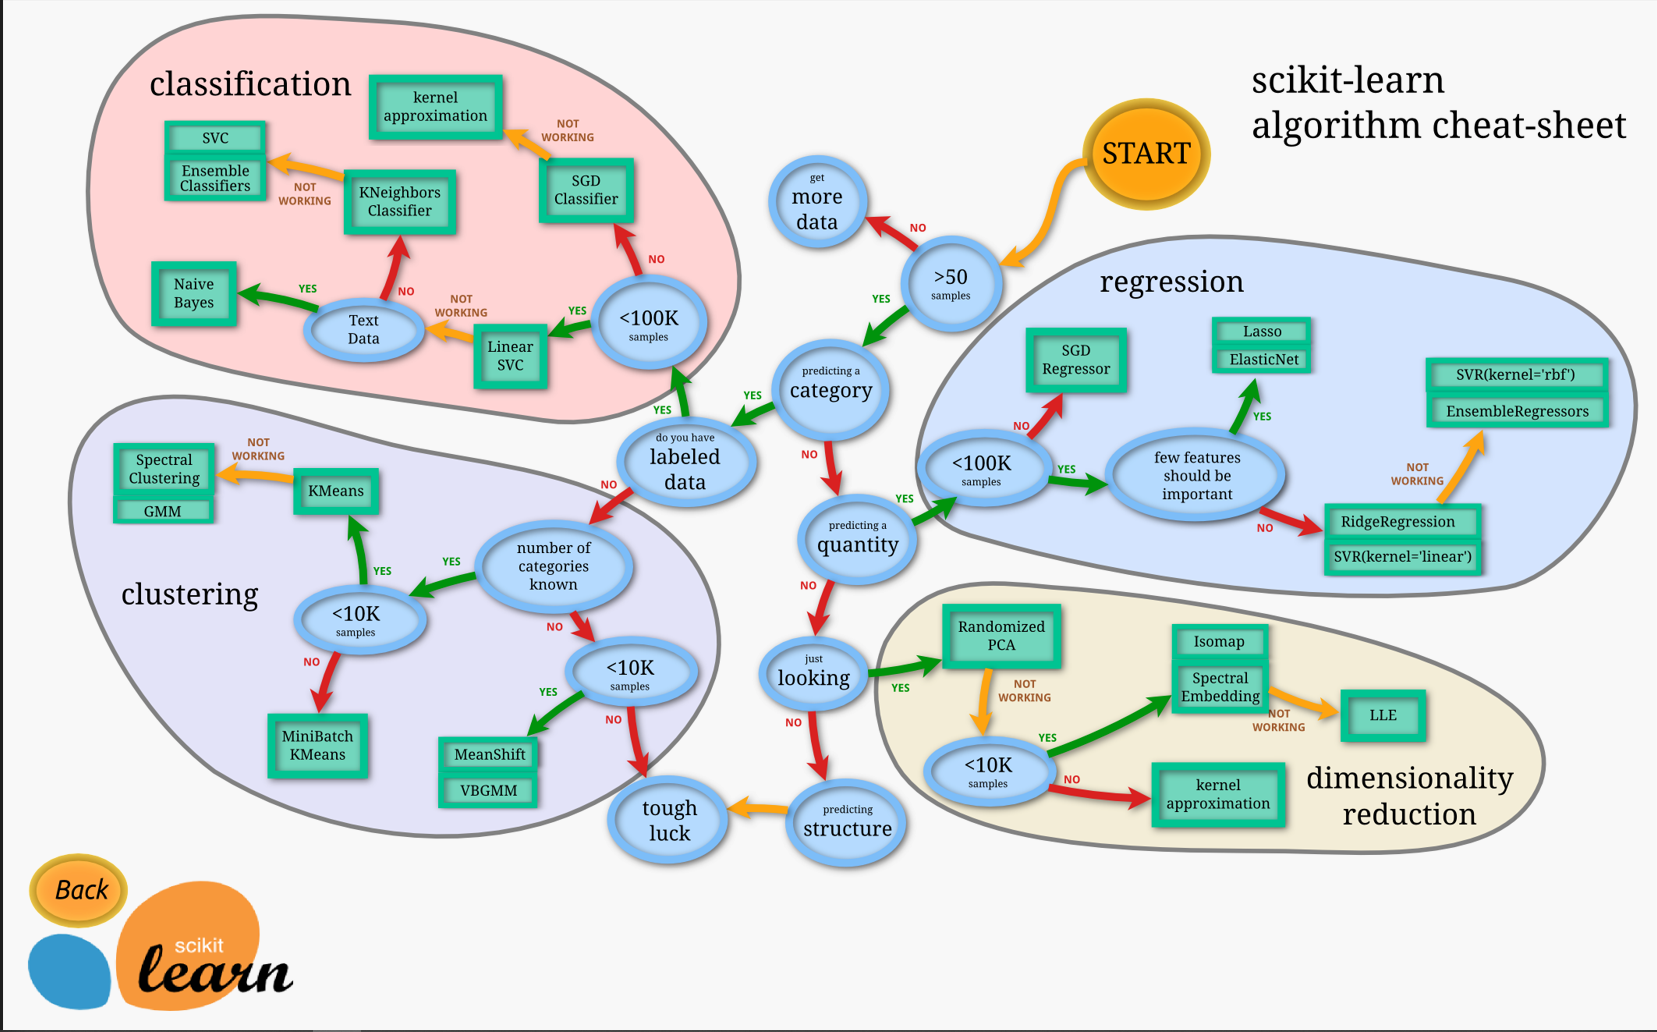
Для более глубокого развития модели придётся обратиться к литературе: 
    
    1. Глубокое обучение в биологии и медицине 2020 Рамсундар Истман
    
    2. https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/discussion/70421 - Первое место
    
    3. https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/discussion/70427 - Второе место
    
    4. Краткая теория алгоритмов на Github: https://github.com/ShauryaBhandari/Machine-Learning

**3. Оценка модели**

**4. Настройка алгоритма (настройка гиперпараметров) для получения наилучшей из возможных моделей. Возвращение в пункт 2**

**5. Отправление результата**

# 1. Обработка данных и визуализация

In [34]:
import os
import pydicom
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import seaborn as sns

import PIL
import torch
import torchvision

# В чём разница между matplotlib и seaborn
Matplotlib и Seaborn - это две библиотеки Python, используемые для визуализации данных. Вот некоторые ключевые различия между ними:

**Matplotlib**:
- Это библиотека Python, используемая для построения графиков с помощью других библиотек, таких как Numpy и Pandas¹.
- Это мощный инструмент для визуализации данных в Python¹.
- Используется для создания статистических выводов и построения 2D-графиков массивов¹.
- Использует Pyplot для предоставления интерфейса, похожего на MATLAB¹.
- Способен работать с различными операционными системами и их графическими бэкэндами¹.

**Seaborn**:
- Это также библиотека Python, используемая для построения графиков с помощью Matplotlib, Pandas и Numpy¹.
- Он построен на основе Matplotlib и считается надстройкой над библиотекой Matplotlib¹.
- Помогает в визуализации одномерных и двумерных данных¹.
- Использует красивые темы для украшения графиков Matplotlib¹.
- Служит важным инструментом при визуализации линейных регрессионных моделей¹.
- Помогает в создании графиков статических временных рядов¹.
- Устраняет перекрытие графиков и также помогает в их украшении¹.

В общем, Seaborn отлично подходит для быстрого создания визуально привлекательных графиков с минимальным кодом, в то время как Matplotlib предлагает больше настроек и более детальный контроль над каждым аспектом графика⁵.

Источник: беседа с Bing, 27.09.2023
(1) Difference Between Matplotlib VS Seaborn - GeeksforGeeks. https://www.geeksforgeeks.org/difference-between-matplotlib-vs-seaborn/.
(2) How to choose between Seaborn vs. Matplotlib - Pierian Training. https://pieriantraining.com/how-to-choose-between-seaborn-vs-matplotlib/.
(3) Matplotlib vs. Seaborn - CodeSolid. https://codesolid.com/matplotlib-vs-seaborn/.
(4) Understanding the Differences Between NumPy, Pandas, Matplotlib, and .... https://alivjung.com/understanding-the-differences-between-numpy-pandas-matplotlib-and-seaborn/.
(5) Python Data Visualization With Seaborn & Matplotlib | Built In. https://builtin.com/data-science/data-visualization-tutorial.

# Зачем нужен plt.rcParams["axes.grid"] = False ?
Эта строка делает так чтобы графики были без сетки

# Зачем нужен import torchvision ?
Это пакет который имеет наборы данных, модели и функции преобразования изображений для CV

# Зачем нужен import glob ?
Модуль glob используется для работы с файлами. Он предоставляет способ искать файлы, которые соответствуют определенному шаблону, что полезно, если вам нужно прочитать несколько файлов из каталога.

In [35]:
seed = 42
num_classes = 2
batch_size = 10
train_img_size = 256 
origin_img_size = 1024
scale_factor = train_img_size / origin_img_size
# np.random.seed(seed)

TRAIN_DIR = "stage_2_train_images"
TEST_DIR = "stage_2_test_images"
ROOT_DIR = "../input/rsna-pneumonia-detection-challenge"
LABELS_FILE = "stage_2_train_labels.csv"
SUBMISSION_FILE = "stage_2_sample_submission.csv"
rcnn_losses = ["loss_objectness", "loss_box_reg", "loss_rpn_box_reg"]

# Зачем нужен seed = 42?

Это значение используется для инициализации генератора случайных чисел. 
Установка seed гарантирует, что результаты случайных операций (например, разделение данных на 
обучающую и тестовую выборки) будут воспроизводимыми. То есть при каждом запуске кода с 
тем же seed результаты будут одинаковыми.

# Что такое batch_size?
Это количество образцов, которые будут передаваться через модель за одну итерацию. 
Batch size влияет на скорость обучения и качество модели. Больший batch size может ускорить 
обучение, но также может привести к более плохому качеству модели.

# Какой оптимальный выбор batch_size?
Выбор оптимального размера пакета (`batch_size`) зависит от нескольких факторов, включая объем данных, архитектуру модели и вычислительные ресурсы. Вот некоторые общие рекомендации:

- Если у вас небольшой набор данных (менее 200 примеров), используйте градиентный спуск с полным пакетом¹.
- Для больших наборов данных обычно используются размеры пакетов 32, 64, 128, 256 или 512¹. Однако, как указано в одном исследовании, оптимальный размер пакета, как правило, будет меньше 32¹.
- Важно убедиться, что мини-пакет помещается в память вашего CPU или GPU¹.
- Более крупные пакеты могут ускорить обучение, но не всегда сходятся так быстро. Меньшие пакеты обучаются медленнее, но могут сходиться быстрее².
- Обычно размер пакета выбирается как степень двойки, в диапазоне от 16 до 512. Но в общем случае размер 32 считается хорошим начальным выбором³.
- Если у вас очень большой набор данных, вы можете использовать эпохи от 50 до 100 с размером пакета 10⁴.

Помните, что эти рекомендации являются общими, и оптимальный размер пакета может варьироваться в зависимости от конкретной задачи и данных.

Source: Conversation with Bing, 9/26/2023
(1) neural networks - How do I choose the optimal batch size? - Artificial .... https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size.
(2) python - How big should batch size and number of epochs be when fitting .... https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model.
(3) Relation Between Learning Rate and Batch Size - Baeldung. https://www.baeldung.com/cs/learning-rate-batch-size.
(4) What Is The Optimal Batch Size For Training A Machine Learning Model .... https://www.surfactants.net/what-is-the-optimal-batch-size-for-training-a-machine-learning-model/.

# Зачем нужны`rcnn_losses = ["loss_objectness", "loss_box_reg", "loss_rpn_box_reg"]`?
Это список названий функций потерь, которые используются в модели Faster R-CNN для обучения. Faster R-CNN - это модель для обнаружения объектов, которая состоит из двух частей: RPN (Region Proposal Network) для генерации предложений областей и Fast R-CNN для классификации и регрессии этих областей. В этом списке:
    - `loss_objectness` - это функция потерь для определения, содержит ли предложенная область объект или нет.
    - `loss_box_reg` - это функция потерь для регрессии ограничивающего прямоугольника, которая корректирует размер и положение предложенной области.
    - `loss_rpn_box_reg` - это функция потерь для регрессии ограничивающего прямоугольника в RPN, которая корректирует размер и положение предложенных областей в RPN.

# Что такое градиентный спуск?
Градиентный спуск - это метод оптимизации, который используется для обучения моделей машинного обучения. Он работает путем минимизации функции потерь, 
которая измеряет разницу между предсказаниями модели и реальными данными.
В контексте задачи обнаружения пневмонии, вы можете использовать модель глубокого обучения, такую как сверточная нейронная сеть (CNN), для обучения на 
изображениях грудной клетки. Функция потерь в этом случае может измерять, насколько хорошо модель может классифицировать изображения как "пневмония" или "не пневмония".
Вот как работает градиентный спуск:
1. **Инициализация**: Сначала модель инициализируется с некоторыми начальными весами. Это могут быть случайные числа или некоторые предварительно определенные значения.
2. **Вычисление функции потерь**: Затем модель делает предсказания на основе текущих весов, и функция потерь вычисляет, насколько хороши эти предсказания.
3. **Вычисление градиента**: Градиент функции потерь по отношению к весам модели вычисляется. Градиент - это вектор, который указывает направление наибольшего увеличения функции, и его размеры соответствуют размерам весов модели.
4. **Обновление весов**: Веса модели затем обновляются в направлении, противоположном градиенту. Это делается путем вычитания некоторой доли градиента из текущих весов. Эта доля называется скоростью обучения.
5. **Повторение**: Этот процесс повторяется многократно, пока функция потерь не станет достаточно малой или пока не будет достигнуто некоторое количество итераций.
Градиентный спуск помогает модели "научиться" правильно классифицировать изображения, минимизируя ошибки в ее предсказаниях. Это делает его очень полезным инструментом 
для обучения моделей машинного обучения.

# Что такое градиентный спуск с полным пакетом?
“Градиентный спуск с полным пакетом”, также известный как “Batch Gradient Descent”, - это вариант градиентного спуска, где “полный пакет” относится к использованию всего набора данных при каждом шаге обучения.
В контексте градиентного спуска, “пакет” - это подмножество обучающих данных, которое используется для вычисления градиента функции потерь. Размер пакета определяет количество
примеров, используемых для одного шага обновления весов модели.
В градиентном спуске с полным пакетом весь набор данных используется для каждого шага обновления. Это означает, что каждый шаг обновления использует информацию от всех примеров 
в наборе данных. Это может быть вычислительно затратно, особенно для больших наборов данных, но оно обеспечивает более точные и стабильные обновления весов.
С другой стороны, в градиентном спуске с мини-пакетами (или стохастическом градиентном спуске) используется только небольшое подмножество данных для каждого шага обновления. Это
может привести к более быстрому, но менее стабильному обучению.
Выбор между этими методами зависит от конкретной задачи и доступных вычислительных ресурсов. В некоторых случаях может быть полезно использовать комбинацию этих методов.



# Какое есть математическое основание использования градиентного спуска в ML?

Градиентный спуск основан на идее, что если функция многих переменных имеет локальный минимум и функция дифференцируема в окрестности этого минимума, то градиент функции в этой точке равен нулю.

В контексте машинного обучения, мы обычно имеем дело с функцией потерь $L(\theta)$, где $\theta$ - это вектор параметров модели. Наша цель - найти значения параметров $\theta$, которые минимизируют функцию потерь.

Градиент функции $L(\theta)$, обозначаемый как $\nabla L(\theta)$, - это вектор, состоящий из частных производных функции потерь по каждому параметру. Это дает нам направление, в котором функция $L(\theta)$ увеличивается быстрее всего. Если мы движемся в противоположном направлении (т.е., делаем шаг в направлении $-\nabla L(\theta)$), мы будем двигаться в направлении наибыстрейшего убывания функции. Это и есть основная идея градиентного спуска.

В градиентном спуске, мы итеративно обновляем параметры модели следующим образом:

$\theta_{new} = \theta_{old} - \alpha \nabla L(\theta_{old})$

где $\alpha$ - это скорость обучения, которая контролирует размер шага. Этот процесс повторяется, пока градиент $\nabla L(\theta)$ не станет достаточно малым или пока не будет достигнуто некоторое количество итераций.

Важно отметить, что градиентный спуск гарантирует сходимость только к локальному минимуму, а не к глобальному. Однако, в практике машинного обучения, особенно при работе с нейронными сетями, эта проблема часто не является существенной, поскольку многие локальные минимумы оказываются достаточно хорошими.

# Что такое функция потерь?
Функция потерь, также известная как функция стоимости, - это ключевой компонент в большинстве алгоритмов машинного обучения. Она измеряет, насколько хорошо модель работает на
данных. В частности, функция потерь вычисляет разницу между предсказаниями модели и реальными значениями.
В контексте задачи классификации, такой как обнаружение пневмонии, функция потерь может измерять, насколько вероятности, предсказанные моделью для каждого класса (например,
“пневмония” или “не пневмония”), отличаются от истинных меток классов.
Цель обучения модели - минимизировать значение функции потерь. Это достигается путем итеративного обновления параметров модели (например, весов в нейронной сети) с использованием
методов оптимизации, таких как градиентный спуск.
Важно отметить, что выбор функции потерь зависит от конкретной задачи. Например, для задач регрессии обычно используется среднеквадратичная ошибка, а для задач 
классификации - перекрестная энтропия. В контексте обнаружения объектов и сегментации изображений могут использоваться более сложные функции потерь.


In [36]:
train_imgs = os.listdir(os.path.join(ROOT_DIR, TRAIN_DIR))
test_imgs = [patientId + ".dcm" for patientId in pd.read_csv(os.path.join(ROOT_DIR, SUBMISSION_FILE)).patientId]

In [37]:
from sklearn.model_selection import train_test_split

train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.33, random_state=seed)

print(f"Number of training samples: {len(train_imgs)}")
print(f"Number of validation samples: {len(valid_imgs)}")

Number of training samples: 17878
Number of validation samples: 8806


# Для чего нужен валидационный набор?
Валидационный набор данных используется в процессе обучения модели машинного обучения и играет важную роль в предотвращении переобучения и оптимизации гиперпараметров модели.

Переобучение происходит, когда модель слишком хорошо подстраивается под обучающие данные и плохо работает на новых данных3. Валидационный набор данных помогает отслеживать производительность модели в процессе обучения и предотвращать переобучение23.

Валидационный набор также используется для настройки гиперпараметров модели14. Гиперпараметры - это параметры, которые задаются до начала обучения и не изменяются в процессе обучения. Примерами гиперпараметров могут быть скорость обучения, количество слоев в нейронной сети и т.д. Валидационный набор позволяет оценить, как изменение гиперпараметров влияет на производительность модели, и выбрать оптимальные значения14.

# Каким считается оптимальный размер валидационного набора от общего числа данных?
Что касается размера валидационного набора, то нет строгих правил, и это может зависеть от конкретной задачи и объема данных. Однако общепринятыми являются следующие рекомендации:

Если у вас достаточно данных, то обычно используют разделение 60% / 20% / 20% для обучающего, валидационного и тестового наборов соответственно5.
Если у вас небольшой объем данных, то может быть полезно использовать кросс-валидацию6.
В некоторых исследованиях предлагается, что доля образцов, зарезервированных для валидационного набора, должна быть обратно пропорциональна квадратному корню из числа свободно настраиваемых параметров6.
В других источниках рекомендуется использовать 80% данных для обучения и 20% для валидации7.
Некоторые исследователи считают, что размер валидационного и тестового наборов должен быть примерно одинаковым8.

# Что если не использовать валидационный набор?
Если не использовать валидационный набор, то может быть сложно определить, когда следует остановить обучение, и сложно настроить гиперпараметры модели. Это может привести к переобучению или недообучению модели.

# Что такое кросс-валидация. Каково её отличие от обычной валидации?
Кросс-валидация и обычная валидация - это две техники, используемые в машинном обучении для оценки производительности модели.

**Обычная валидация**, также известная как **отложенная выборка**, включает разделение набора данных на два подмножества: обучающий набор и валидационный набор. Модель обучается на обучающем наборе и оценивается на валидационном наборе. Это позволяет проверить, насколько хорошо модель обобщает на новые данные.

**Кросс-валидация** - это более сложная техника, которая включает разделение набора данных на k подмножеств, или "блоков". Затем проводится k итераций обучения и валидации, где на каждой итерации модель обучается на k-1 блоках и валидируется на оставшемся блоке. Это позволяет использовать все данные и для обучения, и для валидации, что может привести к более надежной оценке производительности модели.

Основное отличие между кросс-валидацией и обычной валидацией заключается в том, что кросс-валидация использует все данные для обучения и валидации, в то время как обычная валидация использует только часть данных для валидации. Кроме того, кросс-валидация обеспечивает более надежную оценку производительности модели, поскольку она усредняет результаты по k итерациям.

# 1.1 Обработка данных
В файле stage_2_train_labels.csv хранятся координаты ограничительных боксов пневмонии. В нем присутствует большое количество строк с нулевым значением Target и значением NaN в столбцах бокса. Эти строки представляют собой изображения без ограничительных рамок.

In [38]:
train_label_df = pd.read_csv(os.path.join(ROOT_DIR, LABELS_FILE))
train_label_df.head(20)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


Для нашей модели требуются координаты рамки в формате X0, X1. Мы также умножаем координаты ограничительной рамки на scale_factor, поскольку будем обучать нашу модель на изображениях размером 256 вместо их исходного размера 1024. R-CNN также требует в качестве входных данных площадь ограничительной рамки.

In [39]:
isna_count = len(train_label_df[train_label_df.Target == 0]) # Количество фотографий без боксов
train_label_df = train_label_df[train_label_df.Target == 1]
train_label_df.rename(columns = {"x": "X0", "y" : "Y0"}, inplace = True)
train_label_df["X1"] = train_label_df["X0"] + train_label_df["width"]
train_label_df["Y1"] = train_label_df["Y0"] + train_label_df["height"]
train_label_df[["X0", "X1", "Y0", "Y1"]] = train_label_df[["X0", "X1", "Y0", "Y1"]] * scale_factor
train_label_df["area"] = train_label_df["width"] * scale_factor * train_label_df["height"] * scale_factor
train_label_df.drop(["width", "height"], axis = 1, inplace = True)
train_label_df.head()

,patientId,X0,Y0,Target,X1,Y1,area
4,00436515-870c-4b36-a041-de91049b9ab4,66.00,38.00,1,119.25,132.75,5045.4375
5,00436515-870c-4b36-a041-de91049b9ab4,140.50,38.00,1,204.50,151.25,7248.0000
8,00704310-78a8-4b38-8475-49f4573b2dbb,80.75,144.25,1,120.75,170.25,1040.0000
9,00704310-78a8-4b38-8475-49f4573b2dbb,173.75,143.75,1,214.25,178.00,1387.1250
14,00aecb01-a116-45a2-956c-08d2fa55433f,72.00,80.50,1,95.50,114.25,793.1250


# Зачем нужны inplace = True?
В библиотеке pandas для Python, `inplace=True` используется для указания, что операция должна быть выполнена "на месте", то есть изменения должны быть применены непосредственно к исходному объекту DataFrame или Series. 

Если `inplace=False` (по умолчанию), то операция возвращает новый объект, а исходный объект остается неизменным. Если `inplace=True`, то исходный объект изменяется, и операция не возвращает ничего.

В вашем коде `inplace=True` используется в методах `rename` и `drop` для прямого изменения DataFrame `train_label_df`, вместо создания нового DataFrame. Это может быть полезно для экономии памяти, особенно при работе с большими наборами данных.

# 27.09.2023

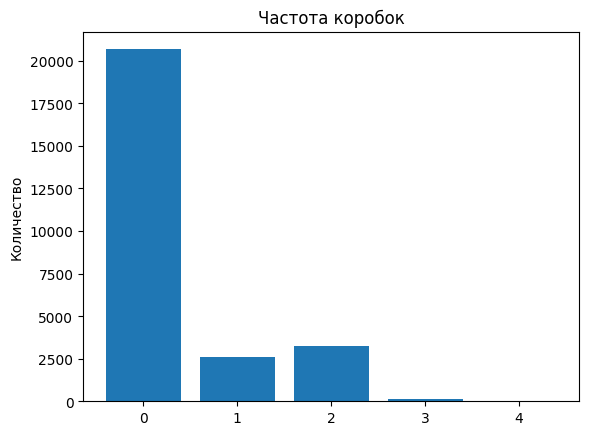

In [40]:
from collections import Counter

cnt = Counter(train_label_df.patientId)
sample_batch = [sample[0] + ".dcm" for sample in cnt.most_common(2)] # Возьмём 2 фотографии с четырьмя боксами чтобы отобразить
counts = pd.Series(cnt.values()).value_counts()
counts[0] = isna_count
plt.title("Частота коробок")
plt.ylabel("Количество")
plt.xticks(counts.index)
plt.bar(counts.index, counts)
plt.show()
del cnt

# Как работает блок?
Этот код использует модуль `collections.Counter` для подсчета количества уникальных значений в столбце `patientId` DataFrame `train_label_df`. Вот что делает каждая строка:

1. `cnt = Counter(train_label_df.patientId)`: Эта строка создает объект `Counter` для столбца `patientId` в DataFrame `train_label_df`. `Counter` возвращает словарь, где ключи - это уникальные значения в столбце `patientId`, а значения - это количество раз, которое каждое уникальное значение встречается в столбце.

2. `sample_batch = [sample[0] + ".dcm" for sample in cnt.most_common(2)]`: Эта строка выбирает два наиболее часто встречающихся значения в `cnt` (то есть два наиболее часто встречающихся `patientId`), добавляет к ним расширение ".dcm" и сохраняет их в списке `sample_batch`.

3. `counts = pd.Series(cnt.values()).value_counts()`: Эта строка преобразует значения `cnt` в объект `pd.Series`, затем подсчитывает количество каждого уникального значения в этом объекте `pd.Series` и сохраняет результаты в `counts`.

4. `counts[0] = isna_count`: Эта строка устанавливает значение `counts` по индексу 0 равным `isna_count`. Предполагается, что `isna_count` - это переменная, определенная где-то ранее в коде.

5. `plt.title("Частота коробок")`, `plt.ylabel("Количество")`, `plt.xticks(counts.index)`, `plt.bar(counts.index, counts)`, `plt.show()`: Эти строки создают график, который отображает количество каждого уникального значения в `counts` (то есть количество раз, которое каждое уникальное количество `patientId` встречается в `train_label_df`).

6. `del cnt`: Эта строка удаляет объект `cnt` для освобождения памяти.

В общем, этот код используется для анализа распределения количества `patientId` в DataFrame `train_label_df` и визуализации результатов.

# Зачем нужен from collections import Counter?
`Counter` - это подкласс в модуле `collections` в Python, который используется для подсчета хешируемых объектов. Он принимает итерируемый объект (например, список) в качестве аргумента и возвращает словарь, в котором ключи - это уникальные элементы в итерируемом объекте, а значения - это количество раз, которое каждый элемент встречается в итерируемом объекте.

Преимущества использования `Counter` по сравнению с ручной инициализацией переменной и инкрементом включают:
1. **Простота использования**: `Counter` автоматически обрабатывает все подсчеты за вас. Вам не нужно инициализировать каждый ключ перед инкрементом его значения.
2. **Быстродействие**: `Counter` оптимизирован для быстрого подсчета элементов в больших наборах данных.
3. **Дополнительные функции**: `Counter` предоставляет дополнительные функции, такие как `most_common([n])`, которая возвращает n наиболее распространенных элементов и их количество от наиболее к наименее распространенным.

Вот пример использования `Counter`:

```python
from collections import Counter

# список с повторяющимися элементами
elements = ['apple', 'banana', 'apple', 'orange', 'banana', 'banana']

# создаем объект Counter
counter = Counter(elements)

print(counter)
```

Этот код выведет: `Counter({'banana': 3, 'apple': 2, 'orange': 1})`, что означает, что 'banana' встречается 3 раза, 'apple' - 2 раза, а 'orange' - 1 раз. Это намного проще и быстрее, чем ручной подсчет каждого элемента.

In [41]:
counts.sort_values(ascending=False)

0    20672
2     3266
1     2614
3      119
4       13
Name: count, dtype: int64

Мы видим, что много изображений не имеют меток, лишь некоторые имеют более двух боксов(меток)

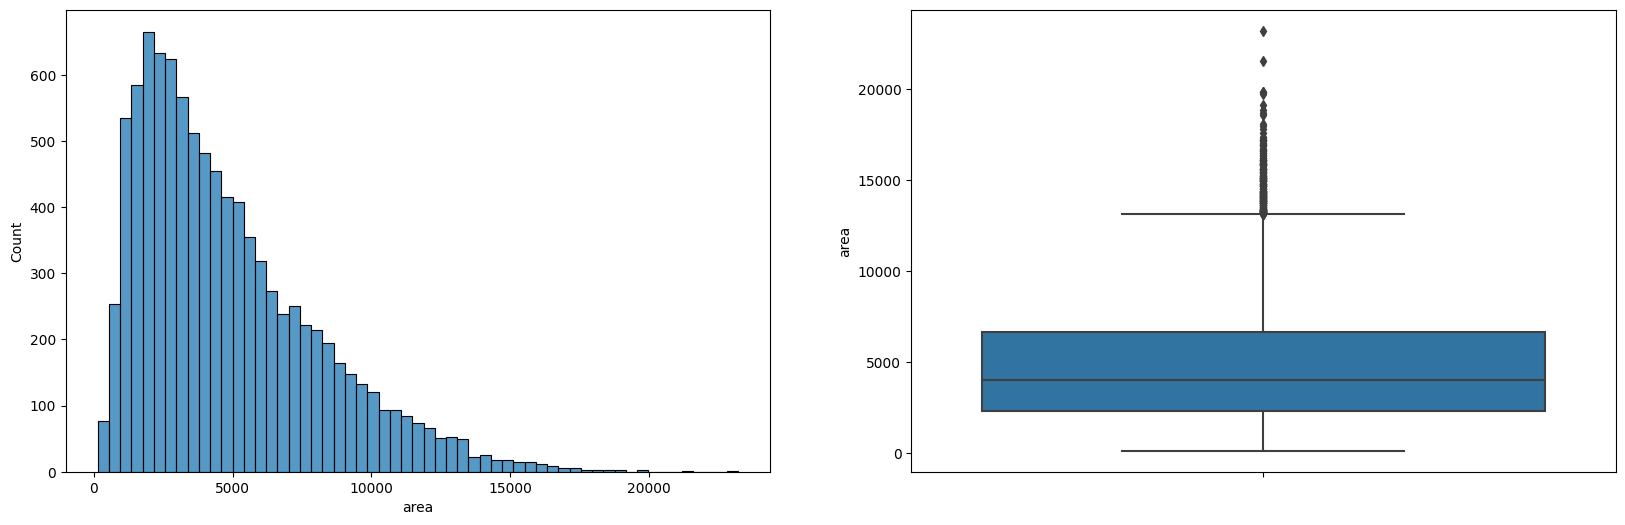

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=train_label_df, x="area", ax=axs[0])
sns.boxplot(y=train_label_df["area"])
plt.show()

# Как работает блок?
Этот код использует библиотеку `matplotlib` и `seaborn` для визуализации данных. Вот что делает каждая строка:

1. `fig, axs = plt.subplots(1,2, figsize = (20, 6))`: Эта строка создает новую фигуру с двумя подграфиками (графиками) в одной строке и двух столбцах. Размер фигуры задается как 20x6.

2. `sns.histplot(data = train_label_df, x = "area", ax = axs[0])`: Эта строка создает гистограмму для столбца "area" в DataFrame `train_label_df` и отображает его на первом подграфике (`axs[0]`).

3. `sns.boxplot(y = train_label_df["area"])`: Эта строка создает ящик с усами (boxplot) для столбца "area" в DataFrame `train_label_df`. По умолчанию, этот график будет отображен на втором подграфике.

4. `plt.show()`: Эта строка отображает созданную фигуру с двумя подграфиками.

В общем, этот код используется для визуализации распределения значений в столбце "area" DataFrame `train_label_df` с помощью гистограммы и ящика с усами. Это может быть полезно для понимания распределения данных и выявления возможных выбросов.

# Что такое гистограмма?
Гистограмма - это способ графического представления табличных данных в виде столбчатой диаграммы¹. Количественные соотношения некоторого показателя представлены в виде прямоугольников, площади которых пропорциональны¹. 

В описательной статистике гистограмма распределения - это наглядное представление функции плотности вероятности некоторой случайной величины, построенное по выборке¹. Иногда её называют частотным распределением, так как гистограмма показывает частоту появления измеренных значений параметров объекта¹.

Гистограмма строится следующим образом. Сначала множество значений, которое может принимать элемент выборки, разбивается на несколько интервалов (bins). Чаще всего эти интервалы берут одинаковыми, но это не является строгим требованием. Эти интервалы откладываются на горизонтальной оси, затем над каждым рисуется прямоугольник¹.

Если все интервалы были одинаковыми, то высота каждого прямоугольника пропорциональна числу элементов выборки, попадающих в соответствующий интервал¹. Если интервалы разные, то высота прямоугольника выбирается таким образом, чтобы его площадь была пропорциональна числу элементов выборки, которые попали в этот интервал¹.

Source: Conversation with Bing, 9/27/2023
(1) Гистограмма — Википедия. https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D1%81%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0.
(2) Что такое гистограмма и как построить этот график: когда используется .... https://alexkolokolov.com/ru/blog/gistogramma-chto-eto-takoe-kogda-ona-ispolzuetsya.
(3) Гистограмма - это... Что такое гистограмма: гистограмма в статистике .... https://biznes-prost.ru/gistogramma.html.
(4) Гистограмма | это... Что такое Гистограмма?. https://dic.academic.ru/dic.nsf/ruwiki/24310.

Видно, что большинство ящиков имеют площадь меньше 7000. Есть и сэмплы с площадью более 15000. Теперь определим несколько вспомогательных функций для отображения сэмплов вместе с коробками.

/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


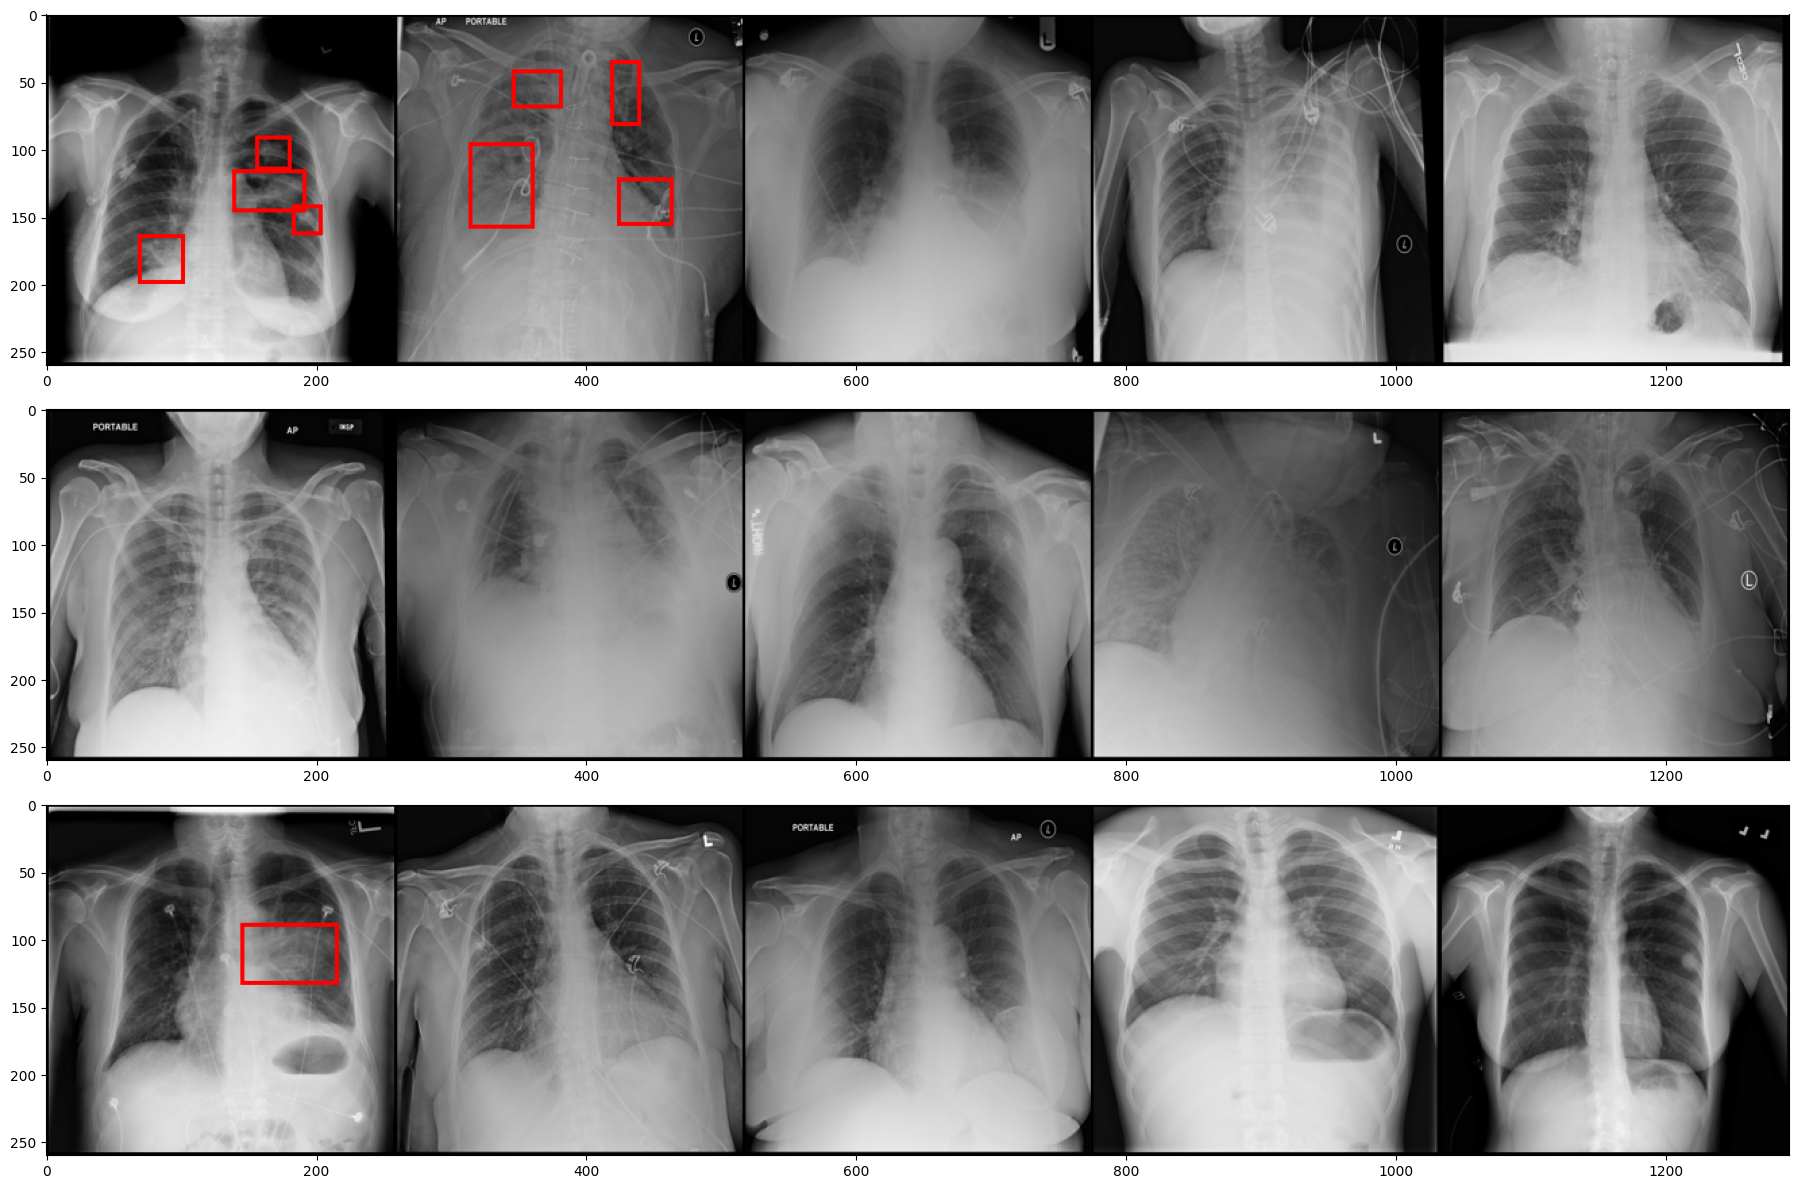

In [43]:
## from torchvision.utils import draw_bounding_boxes, make_grid


def find_boxes(img_name, label_df): 
    patient_id = img_name.split(".")[0]
    boxes = label_df[label_df.patientId == patient_id]
    boxes_coord = boxes[["X0", "Y0", "X1", "Y1"]].to_numpy()
    return boxes_coord, boxes.area.to_numpy()

def read_images(img_names, label_df, resize):
    batch = []
    for img_name in img_names:
        img_path = os.path.join(ROOT_DIR, TRAIN_DIR, img_name)
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(resize)
        img = np.array(img)
       
        boxes, _ = find_boxes(img_name, label_df)

        img = torch.tensor(img, dtype=torch.uint8)
        boxes = torch.tensor(boxes, dtype=torch.int32)
        batch.append((img, boxes))
    return batch

def plot_samples(batch, n_rows=3, n_cols=5, box_color="red", titles=None, box_width=3, fig_size=(20,12)):
    assert len(batch) >= n_rows * n_cols, f"Не достаточно сэмплов для отображения, необходимо по-крайней мере {n_rows * n_cols} сэмплов"
    fig, axs = plt.subplots(n_rows, 1, figsize=fig_size)
    fig.tight_layout()
    imgs_with_boxes = []
    for sample in batch[:n_rows * n_cols]:
        scores = None
        if len(sample) == 2:
            image, boxes = sample
        else:
            image, boxes, scores = sample 
            scores = [f"Score: {score:.2f}" for score in scores]
            
        img = draw_bounding_boxes(image=image.permute(2, 0, 1), 
                                  boxes=boxes, 
                                  colors=box_color, 
                                  labels=scores,
                                  width=box_width)
        imgs_with_boxes.append(img)
        
    for i, ax in enumerate(axs): 
        if titles:
            ax.set_title(titles[i], fontsize=18)
        img_with_boxes = make_grid(imgs_with_boxes[i * n_cols: (i + 1) * n_cols]).numpy()       
        ax.imshow(np.transpose(img_with_boxes, (1, 2, 0)))
    plt.show()
       
    
sample_batch = np.concatenate([sample_batch, np.random.choice(train_imgs, size=13)])
sample_batch = read_images(sample_batch, train_label_df, (train_img_size, train_img_size))
plot_samples(sample_batch)

# Какова логика этого блока?
Этот код использует библиотеки Python для обработки изображений и визуализации данных. Вот что делает каждая функция:

1. `find_boxes(img_name, label_df)`: Эта функция принимает имя изображения и DataFrame с метками. Она извлекает идентификатор пациента из имени изображения, затем находит все строки в DataFrame, которые соответствуют этому идентификатору пациента. Затем она извлекает координаты рамок из этих строк и возвращает их вместе с площадями рамок.

2. `read_images(img_names, label_df, resize)`: Эта функция принимает список имен изображений, DataFrame с метками и размер для изменения размера изображений. Она читает каждое изображение, изменяет его размер, находит рамки для этого изображения с помощью функции `find_boxes`, затем добавляет изображение и рамки в пакет.

3. `plot_samples(batch, n_rows=3, n_cols=5, box_color="red", titles=None, box_width=3, fig_size=(20,12))`: Эта функция принимает пакет изображений и рамок, а также различные параметры для настройки визуализации. Она создает график с заданным количеством строк и столбцов, затем отображает каждое изображение в пакете с соответствующими рамками.

4. `sample_batch = np.concatenate([sample_batch, np.random.choice(train_imgs, size=13)])`: Эта строка добавляет 13 случайных изображений из `train_imgs` в `sample_batch`.

5. `sample_batch = read_images(sample_batch, train_label_df, (train_img_size, train_img_size))`: Эта строка читает все изображения в `sample_batch`, изменяет их размер и находит рамки для каждого изображения.

6. `plot_samples(sample_batch)`: Эта строка отображает все изображения в `sample_batch` с соответствующими рамками.

В общем, этот код используется для чтения изображений, нахождения рамок на этих изображениях и визуализации результатов.

# Зачем нужен from torchvision.utils import draw_bounding_boxes, make_grid?
`draw_bounding_boxes` и `make_grid` - это функции из модуля `torchvision.utils` в библиотеке PyTorch¹². 

- `draw_bounding_boxes` используется для отрисовки ограничивающих рамок на изображении¹⁴. Она принимает тензор изображения и тензор, содержащий координаты ограничивающих рамок, и возвращает тензор изображения с нарисованными рамками¹⁴. Это может быть полезно при визуализации результатов моделей обнаружения объектов².

- `make_grid` используется для создания тензора, который представляет собой сетку изображений²³. Она принимает список тензоров изображений и возвращает один тензор, который можно использовать для отображения всех изображений в сетке²³. Это полезно, когда вы хотите визуализировать несколько изображений одновременно².

Обе эти функции широко используются для визуализации данных и результатов в области компьютерного зрения¹².

Source: Conversation with Bing, 9/27/2023
(1) draw_bounding_boxes — Torchvision 0.15 documentation. https://pytorch.org/vision/stable/generated/torchvision.utils.draw_bounding_boxes.html.
(2) Visualization utilities — Torchvision 0.15 documentation. https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html.
(3) How to draw bounding boxes on an image in PyTorch?. https://www.geeksforgeeks.org/how-to-draw-bounding-boxes-on-an-image-in-pytorch/.
(4) visualization - pytorch make_grid (from torchvision.utils import make .... https://stackoverflow.com/questions/68579467/pytorch-make-grid-from-torchvision-utils-import-make-grid-behaves-different-th.
(5) Drawing transparent bounding boxes with Torchvision. https://datascience.stackexchange.com/questions/117447/drawing-transparent-bounding-boxes-with-torchvision.

# Как работает функция find_boxes?
Функция `find_boxes` принимает два аргумента: `img_name` (имя изображения) и `label_df` (DataFrame с метками). Вот что делает каждая строка функции:

1. `patient_id = img_name.split(".")[0]`: Эта строка разделяет имя изображения по символу точки и берет первую часть в качестве идентификатора пациента. Например, если `img_name` равно "12345.dcm", то `patient_id` будет равно "12345".

2. `boxes = label_df[label_df.patientId == patient_id]`: Эта строка выбирает все строки из DataFrame `label_df`, где значение в столбце `patientId` равно `patient_id`. Результат сохраняется в переменной `boxes`.

3. `boxes_coord = boxes[["X0", "Y0", "X1", "Y1"]].to_numpy()`: Эта строка выбирает столбцы "X0", "Y0", "X1" и "Y1" из DataFrame `boxes` и преобразует их в массив numpy. Эти столбцы представляют собой координаты ограничивающих рамок на изображении.

4. `return boxes_coord, boxes.area.to_numpy()`: Эта строка возвращает два значения: массив numpy с координатами ограничивающих рамок и массив numpy с площадями этих рамок.

В общем, эта функция используется для извлечения координат и площадей ограничивающих рамок для конкретного пациента на основе его идентификатора, который извлекается из имени изображения.

# Как работает функция read_images?
Функция `read_images` принимает три аргумента: список имен изображений (`img_names`), DataFrame с метками (`label_df`) и размер для изменения размера изображений (`resize`). Она возвращает список кортежей, где каждый кортеж содержит изображение и соответствующие ему рамки. Вот что делает каждая строка функции:

1. `batch = []`: Эта строка инициализирует пустой список `batch`, который будет заполнен кортежами изображений и рамок.

2. `for img_name in img_names:`: Эта строка начинает цикл, который проходит по каждому имени изображения в списке `img_names`.

3. `img_path = os.path.join(ROOT_DIR, TRAIN_DIR, img_name)`: Эта строка создает путь к изображению, объединяя `ROOT_DIR`, `TRAIN_DIR` и `img_name`.

4. `img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")`: Эта строка читает изображение DICOM по указанному пути, преобразует его в массив numpy, затем преобразует этот массив в изображение PIL и конвертирует его в формат RGB.

5. `img = img.resize(resize)`: Эта строка изменяет размер изображения PIL в соответствии с заданным размером `resize`.

6. `img = np.array(img)`: Эта строка преобразует изображение PIL обратно в массив numpy.

7. `boxes, _ = find_boxes(img_name, label_df)`: Эта строка вызывает функцию `find_boxes` с именем изображения и DataFrame с метками в качестве аргументов. Она получает координаты рамок для изображения и игнорирует возвращаемые площади рамок.

8. `img = torch.tensor(img, dtype=torch.uint8)`: Эта строка преобразует массив numpy изображения в тензор PyTorch типа uint8.

9. `boxes = torch.tensor(boxes, dtype=torch.int32)`: Эта строка преобразует массив numpy с координатами рамок в тензор PyTorch типа int32.

10. `batch.append((img, boxes))`: Эта строка добавляет кортеж, содержащий тензор изображения и тензор рамок, в список `batch`.

11. `return batch`: Эта строка возвращает список `batch` после завершения цикла.

В общем, эта функция используется для чтения изображений, изменения их размера, нах

# Как работает функция plot_samples?
Функция `plot_samples` используется для визуализации изображений с рамками в виде сетки на одной фигуре. Вот что делают первые пять строк функции:

assert = утверждать

1. `assert len(batch) >= n_rows * n_cols, f"Не достаточно сэмплов для отображения, необходимо по-крайней мере {n_rows * n_cols} сэмплов"`: Эта строка проверяет, что в пакете достаточно изображений для отображения в заданном количестве строк и столбцов. Если это не так, она вызывает исключение с сообщением об ошибке.

2. `fig, axs = plt.subplots(n_rows, 1, figsize=fig_size)`: Эта строка создает новую фигуру с заданным количеством строк и одним столбцом. Размер фигуры задается параметром `fig_size`.

3. `fig.tight_layout()`: Эта строка автоматически настраивает расположение подграфиков на фигуре, чтобы они не перекрывались.

4. `imgs_with_boxes = []`: Эта строка инициализирует пустой список `imgs_with_boxes`, который будет заполнен изображениями с нарисованными рамками.

5. `for sample in batch[:n_rows * n_cols]:`: Эта строка начинает цикл, который проходит по каждому образцу в пакете. Количество образцов, которые будут обработаны, ограничивается `n_rows * n_cols`.

6. `scores = None`: Эта строка инициализирует переменную `scores` как `None`. Эта переменная будет использоваться для хранения меток для рамок, если они есть.

7. `if len(sample) == 2: image, boxes = sample else: image, boxes, scores = sample`: Эта строка проверяет, сколько элементов содержит образец. Если образец содержит два элемента, то это изображение и рамки. Если образец содержит три элемента, то это изображение, рамки и метки. Эта строка распаковывает элементы образца в соответствующие переменные.

8. `scores = [f"Score: {score:.2f}" for score in scores]`: Эта строка форматирует метки для рамок, добавляя префикс "Score:" и округляя значения до двух знаков после запятой.

9. `img = draw_bounding_boxes(image=image.permute(2, 0, 1), boxes=boxes, colors=box_color, labels=scores, width=box_width)`: Эта строка рисует рамки на изображении с помощью функции `draw_bounding_boxes`. Она принимает тензор изображения, тензор рамок, цвет рамок, метки для рамок и ширину рамок.

10. `imgs_with_boxes.append(img)`: Эта строка добавляет изображение с рамками в список `imgs_with_boxes`.

11. `for i, ax in enumerate(axs):`: Эта строка начинает другой цикл, который проходит по каждому подграфику на фигуре.

12. `if titles: ax.set_title(titles[i], fontsize=18)`: Если предоставлен список заголовков, эта строка устанавливает заголовок текущего подграфика.

13. `img_with_boxes = make_grid(imgs_with_boxes[i * n_cols: (i + 1) * n_cols]).numpy()`: Эта строка создает сетку изображений с рамками с помощью функции `make_grid`, затем преобразует результат в массив numpy.

14. `ax.imshow(np.transpose(img_with_boxes, (1, 2, 0)))`: Эта строка отображает сетку изображений на текущем подграфике.

15. `plt.show()`: Эта строка отображает созданную фигуру с подграфиками. 

# 28.09.2023

# Что такое тензор?
В математике тензор - это математический объект, который в общем случае может быть представлен как многомерный массив чисел, организованный определенным образом. Тензоры являются обобщением скаляров (нульмерных тензоров), векторов (одномерных тензоров) и матриц (двумерных тензоров) на многомерное пространство.

В контексте машинного обучения и, в частности, библиотеки TensorFlow, тензоры используются для представления данных. Они могут иметь любое количество измерений, и благодаря этому удобны для работы с различными типами данных. Например, изображение может быть представлено в виде трехмерного тензора, где оси соответствуют высоте, ширине и цветовым каналам.

# Что делает функция image.permute()?
Функция `permute()` в PyTorch используется для изменения порядка измерений тензора. В данном случае, `permute(2, 0, 1)` меняет порядок измерений тензора изображения.

Если исходный тензор изображения имеет форму (высота, ширина, каналы), то после применения `permute(2, 0, 1)`, порядок измерений становится (каналы, высота, ширина). Это обычно делается, потому что многие функции в PyTorch ожидают тензоры изображений в формате (каналы, высота, ширина).

# Что означает for i,j in enumerate(...)?
В Python `enumerate()` - это встроенная функция, которая позволяет перебирать элементы итерируемого объекта (например, списка) и в то же время иметь доступ к индексу текущего элемента.

Когда вы используете `for i, j in enumerate(...)`, `i` - это индекс текущего элемента, а `j` - это сам элемент. Это очень полезно, когда вам нужно не только значение элемента, но и его позиция в итерируемом объекте.

Вот пример:

```python
список = ['яблоко', 'банан', 'вишня']
for i, j in enumerate(список):
    print(f"Элемент {j} находится на позиции {i} в списке.")
```

Этот код выведет:

```
Элемент яблоко находится на позиции 0 в списке.
Элемент банан находится на позиции 1 в списке.
Элемент вишня находится на позиции 2 в списке.
```
😊

# Вывод print(f"The value is equal to {element}"), зачем писать f?
В Python `print()` - это функция, которая выводит указанный текст на экран. Когда вы пишете `print(f"text")`, вы используете так называемую f-строку (форматированную строку). 

F-строки позволяют вставлять значения переменных прямо в строку. Это делается путем помещения переменной в фигурные скобки `{}` внутри строки. Например:

```python
имя = "Алексей"
print(f"Привет, {имя}!")
```

Этот код выведет: `Привет, Алексей!`

Таким образом, f-строки очень удобны для создания сложных строк с переменными.

Если вы напишете `print("text")` без `f` перед строкой, то Python просто выведет текст внутри кавычек. Однако, если вы попытаетесь вставить переменную внутрь строки без `f`, Python воспримет это буквально, а не как имя переменной. 

Например:

```python
имя = "Алексей"
print("Привет, {имя}!")
```

Этот код выведет: `Привет, {имя}!`, а не `Привет, Алексей!`. 

Таким образом, `f` перед строкой необходим для того, чтобы Python понимал, что в фигурных скобках находится имя переменной, значение которой нужно вставить в строку.

# 1.2 Искусственное увеличение числа данных (Image augmentation)
Теперь мы воспользуемся удобной библиотекой для увеличения изображений imgaug. Библиотека может выполнять геометрические преобразования, а также создавать ограничительные рамки, маски и ключевые точки. Кроме того, мы добавим к изображению шум и размытие.

In [44]:
import imgaug
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

class Augmentation:
    def __init__(self, 
                 x_translation=(-0.05, 0.05), 
                 rotate=(-5, 5),
                 scale=(0.9, 1.1),
                 noice=(0, 10),
                 blur=(0, 0.1)):
        
        self.transform = iaa.Sequential([            
            iaa.Affine(translate_percent={"x": x_translation}, scale=scale, rotate=rotate),
            iaa.AdditiveGaussianNoise(scale=noice),
            iaa.GaussianBlur(sigma=blur)])
    
    def __call__(self, image, boxes): 
        bbs = BoundingBoxesOnImage([BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3]) 
                                    for box in boxes], shape=image.shape)
        
        image, bbs = self.transform(image=image, bounding_boxes=bbs)
        return image, bbs.to_xyxy_array()

    def worker_init_fn(self, worker_id):
        """Set unique seed for each worker."""
        imgaug.seed(np.random.get_state()[1][0] + worker_id)
        
from torchvision.transforms import PILToTensor, ConvertImageDtype

class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, img_names, train_img_size, labels=None):
        self.root = root
        self.transforms = transforms
        self.img_names = img_names
        self.resize = (train_img_size, train_img_size)       
        self.labels = labels
        
    def __getitem__(self, idx):
        """Load image, boxes and process them"""
        img_name = self.img_names[idx]
       
        img_path = os.path.join(self.root, self.img_names[idx])
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(self.resize)
        img = np.array(img)
                 
        if self.labels is None:           
            return torch.tensor(img / 255.).permute(2, 0, 1).float() 
        
        boxes, area = find_boxes(img_name, self.labels)
        n_objects = len(boxes) 
        if self.transforms is not None:            
            img, boxes = self.transforms(img, boxes)
            
        img = torch.tensor(img / 255.).permute(2, 0, 1).float() 
               
        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.ones(n_objects, dtype=torch.int64)
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.zeros(n_objects, dtype=torch.int32)
        return img, target
        
    def __len__(self):
        return len(self.img_names)
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))    

# Как работают классы в Pyhton? 
Классы в Python работают похожим образом на классы в C++ или Java, но есть некоторые различия. Вот краткое описание:

- **Определение класса**: Классы определяются с помощью ключевого слова `class`, за которым следует имя класса и двоеточие. Тело класса записывается с отступом.

```python
class MyClass:
    ...
```

- **Атрибуты и методы**: Атрибуты и методы класса определяются внутри тела класса. Методы - это просто функции, определенные внутри класса.

```python
class MyClass:
    attribute = "value"

    def method(self):
        return "Hello, world!"
```

- **`self`**: В отличие от C++, в Python первый параметр каждого метода класса - это ссылка на сам объект. Этот параметр обычно называется `self`.

- **Конструктор**: Конструктор класса в Python - это специальный метод под названием `__init__`. Он вызывается при создании объекта класса.

```python
class MyClass:
    def __init__(self):
        self.attribute = "value"
```

- **Создание объектов**: Объекты класса создаются путем вызова имени класса как функции.

```python
obj = MyClass()
```

- **Доступ к атрибутам и методам**: Доступ к атрибутам и методам объекта осуществляется через точку, как и в C++.

```python
print(obj.attribute)  # Выводит: value
print(obj.method())  # Выводит: Hello, world!
```


# Зачем в python при работе с классами используется двойное подчёркивание?
В Python двойное подчеркивание перед и после имени метода или атрибута имеет специальное значение. Это соглашение используется для определения специальных методов, иногда называемых "магическими" методами.

Например, метод `__init__` - это специальный метод, который вызывается при создании объекта класса. Это то, что мы обычно называем конструктором в других языках программирования.

Другой пример - метод `__call__`, который позволяет объектам класса вести себя как функции. То есть, объект этого класса можно "вызвать" как функцию.

Важно отметить, что двойное подчеркивание также используется для создания "приватных" атрибутов и методов класса, которые не предназначены для использования вне класса. Например, `__private_method`. Однако, в отличие от некоторых других языков, в Python это не строгое ограничение, а скорее соглашение между программистами.

Важно отметить, что в Python нет строгого понятия “приватности”, как в C++ или Java. Даже если метод или атрибут начинается с двойного подчеркивания, вы все равно можете получить к нему доступ извне класса, хотя это и считается плохой практикой.

# Как работает метод call в классах Python?
Метод `__call__` в Python позволяет объекту класса вести себя как функцию. То есть, объект этого класса можно "вызвать" как функцию. 

Вот пример:

```python
class Example:
    def __init__(self, value=0):
        self.value = value

    def __call__(self, x):
        return self.value * x

e = Example(2)
print(e(3))  # Выводит: 6
```

В этом примере, мы создаем объект `e` класса `Example`. Затем мы "вызываем" объект `e` как функцию, передавая ему аргумент `3`. Это вызывает метод `__call__` объекта `e`, который возвращает произведение `self.value` и `x`. В результате, `print(e(3))` выводит `6`.

Таким образом, метод `__call__` позволяет нам использовать объекты как функции, что может быть очень удобно в некоторых случаях. Надеюсь, это помогло! Если у вас есть еще вопросы, не стесняйтесь задавать. 😊

# 29.09.2023

# Как реализуется class Augmentation?
Ваш код определяет класс `Augmentation`, который используется для аугментации изображений и ограничивающих рамок (bounding boxes). Вот построчное объяснение:

1. `class Augmentation:` - Определение класса `Augmentation`.

2. `def __init__(self, x_translation=(-0.05, 0.05), rotate=(-5, 5), scale=(0.9, 1.1), noice=(0, 10), blur=(0, 0.1)):` - Это конструктор класса, который инициализирует новый экземпляр класса `Augmentation` с заданными параметрами аугментации.

3. `self.transform = iaa.Sequential([...])` - Здесь создается объект `iaa.Sequential`, который представляет собой последовательность преобразований (аугментаций), которые будут применяться к изображениям и ограничивающим рамкам.

4. `def __call__(self, image, boxes):` - Это специальный метод, который позволяет экземплярам класса вести себя как вызываемые объекты (функции). Он принимает изображение и список ограничивающих рамок.

5. `bbs = BoundingBoxesOnImage([...], shape=image.shape)` - Здесь создается объект `BoundingBoxesOnImage`, который представляет собой список ограничивающих рамок на изображении.

6. `image, bbs = self.transform(image=image, bounding_boxes=bbs)` - Здесь `self.transform` (последовательность аугментаций) применяется к изображению и ограничивающим рамкам.

7. `return image, bbs.to_xyxy_array()` - Затем метод возвращает аугментированное изображение и обновленные ограничивающие рамки.

8. `def worker_init_fn(self, worker_id):` - Это дополнительный метод, который используется для инициализации каждого рабочего процесса с уникальным seed для генератора случайных чисел.

9. `imgaug.seed(np.random.get_state()[1][0] + worker_id)` - Здесь устанавливается уникальный seed для генератора случайных чисел в каждом рабочем процессе. Это гарантирует, что каждый рабочий процесс будет генерировать уникальные случайные числа, что важно для процесса аугментации. 

В общем, этот класс используется для аугментации изображений и ограничивающих рамок с использованием различных преобразований, таких как аффинные преобразования, добавление гауссовского шума и гауссовское размытие. Это может быть полезно при обучении моделей компьютерного зрения, чтобы улучшить их способность распознавать объекты в различных условиях и ориентациях.

# Как работает строка self.transform = iaa.Sequential([...])?
Этот код создает последовательность преобразований (аугментаций), которые будут применяться к изображениям и ограничивающим рамкам. Вот что делает каждая строка:

- `self.transform = iaa.Sequential([...])`: Создает объект `iaa.Sequential`, который представляет собой последовательность преобразований. Эти преобразования будут применяться к изображениям и ограничивающим рамкам в указанном порядке.

- `iaa.Affine(translate_percent={"x": x_translation}, scale=scale, rotate=rotate)`: Создает аффинное преобразование, которое может перемещать, масштабировать и поворачивать изображение. Параметры `x_translation`, `scale` и `rotate` определяют, насколько сильно будет применяться каждое преобразование.

- `iaa.AdditiveGaussianNoise(scale=noice)`: Добавляет гауссовский шум к изображению. Параметр `noice` определяет стандартное отклонение гауссовского распределения шума.

- `iaa.GaussianBlur(sigma=blur)`: Применяет гауссовское размытие к изображению. Параметр `blur` определяет стандартное отклонение гауссовского ядра, используемого для размытия.

В результате, `self.transform` будет содержать последовательность этих преобразований, которые затем можно применить к изображению и ограничивающим рамкам с помощью метода `__call__`. Это полезно для увеличения разнообразия обучающих данных при обучении моделей компьютерного зрения.

# Что такое аффинное преобразование?
Аффинное преобразование - это тип геометрического преобразования, которое сохраняет коллинеарность (то есть, все точки, лежащие на линии до преобразования, все еще лежат на линии после преобразования) и отношения расстояний между точками на линии⁴. 

В евклидовой геометрии аффинное преобразование или аффинность (от латинского affinis, "связанный с") - это геометрическое преобразование, которое сохраняет линии и параллельность, но не обязательно евклидовы расстояния и углы¹. 

Примеры аффинных преобразований включают перенос, масштабирование, гомотетию, сходство, отражение, вращение, сдвиг, спиральные сходства и перевод, а также их комбинации в любом порядке и последовательности¹.

В общем, аффинное преобразование - это композиция вращений, переносов, масштабирований и сдвигов². В то время как аффинное преобразование сохраняет пропорции на линиях, оно не обязательно сохраняет углы или длины². 

Таким образом, любой треугольник может быть преобразован в любой другой с помощью аффинного преобразования, поэтому все треугольники являются аффинными и, в этом смысле, аффинное является обобщением конгруэнтного и подобного².

В математическом контексте аффинное преобразование может быть представлено как линейное преобразование, за которым следует перенос. Если мы имеем вектор **x** в n-мерном пространстве, аффинное преобразование **A** этого вектора может быть записано как:

**y = Ax + b**

где **A** - это матрица преобразования, **b** - вектор переноса, а **y** - это результат преобразования.

В случае двумерного пространства, матрица преобразования **A** и вектор переноса **b** могут выглядеть следующим образом:

**A** = $\begin{bmatrix} a & b \\ c & d \end{bmatrix}$

**b** = $\begin{bmatrix} e \\ f \end{bmatrix}$

Тогда аффинное преобразование вектора **x** = $\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$ будет выглядеть так:

**y** = $\begin{bmatrix} a & b \\ c & d \end{bmatrix}$ $\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$ + $\begin{bmatrix} e \\ f \end{bmatrix}$

Это преобразование включает в себя масштабирование, вращение и сдвиг вектора **x**. Масштабирование и вращение выполняются с помощью матрицы **A**, а сдвиг - с помощью вектора **b**. 

Source: Conversation with Bing, 9/29/2023
(1) Affine transformations | Brilliant Math & Science Wiki. https://brilliant.org/wiki/affine-transformations/.
(2) Affine transformation - Wikipedia. https://en.wikipedia.org/wiki/Affine_transformation.
(3) Affine Transformation -- from Wolfram MathWorld. https://mathworld.wolfram.com/AffineTransformation.html.
(4) Meaning of affine transformation - Mathematics Stack Exchange. https://math.stackexchange.com/questions/93930/meaning-of-affine-transformation.
(5) Affine transformation - Wikiwand. https://www.wikiwand.com/en/Affine_transformation.

# Что такое Евклидово расстояние?
Евклидово расстояние определяется как длина отрезка между двумя точками в Евклидовом пространстве. Оно может быть вычислено из координат точек с использованием теоремы Пифагора, поэтому иногда его называют Пифагоровым расстоянием.

1. **Евклидово расстояние**: Если у нас есть две точки в n-мерном пространстве, **p** = (p₁, p₂, ..., pₙ) и **q** = (q₁, q₂, ..., qₙ), то Евклидово расстояние между ними определяется как:

   d(p, q) = $\sqrt{(q₁ - p₁)² + (q₂ - p₂)² + ... + (qₙ - pₙ)²}$

# Что такое L2-норма?
L2-норма, также известная как евклидова норма, - это мера длины (или магнитуды) вектора¹. Она определяется как квадратный корень из суммы квадратов всех компонент вектора¹. 

Если у нас есть вектор **x** = (x₁, x₂, ..., xₙ) в n-мерном пространстве, то L2-норма этого вектора определяется как: ||x|| = $\sqrt{x₁² + x₂² + ... + xₙ²}$

L2-норма часто используется в машинном обучении и других областях, таких как компьютерное зрение и обработка сигналов, где она может служить мерой расстояния между векторами или мерой ошибки³.

Source: Conversation with Bing, 9/29/2023
(1) L^2-Norm -- from Wolfram MathWorld. https://mathworld.wolfram.com/L2-Norm.html.
(2) Gentle Introduction to Vector Norms in Machine Learning. https://machinelearningmastery.com/vector-norms-machine-learning/.
(3) Understanding L1 and L2 norms - Mathematics Stack Exchange. https://math.stackexchange.com/questions/4014974/understanding-l1-and-l2-norms.
(4) Vector Norms: A Quick Guide | Built In. https://builtin.com/data-science/vector-norms.

# Что такое функция распределения Гаусса?
Гауссовское распределение, также известное как нормальное распределение, - это тип непрерывного распределения вероятностей для вещественной случайной величины¹. Общая форма его функции плотности вероятности представляет собой "колоколообразную" кривую и определяется следующим образом²:

G(x) = $\frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$

где μ - это среднее значение (или математическое ожидание) распределения, а σ - это стандартное отклонение².


**Гауссовская функция**: Гауссовская функция в двух измерениях определяется следующим образом:

   G(x, y) = $\frac{1}{2πσ²} e^{-(x² + y²) / 2σ²}$

   где x и y - это расстояния от центра гауссовской функции, а σ - это стандартное отклонение гауссовского распределения.

Стандартное отклонение гауссовского распределения, обозначаемое σ, - это мера, которая показывает, насколько интенсивно значения случайной величины отклоняются от среднего значения⁶.

Source: Conversation with Bing, 9/29/2023
(1) . https://bing.com/search?q=Gaussian+distribution+definition.
(2) Normal distribution - Wikipedia. https://en.wikipedia.org/wiki/Normal_distribution.
(3) Mean and standard deviation of Gaussian Distribution. https://stats.stackexchange.com/questions/20744/mean-and-standard-deviation-of-gaussian-distribution.
(4) Gaussian Distribution Definition | DeepAI. https://deepai.org/machine-learning-glossary-and-terms/gaussian-distribution.
(5) Normal distribution | Definition, Examples, Graph, & Facts. https://www.britannica.com/topic/normal-distribution.
(6) What does gaussian distribution mean? - Definitions.net. https://www.definitions.net/definition/gaussian%20distribution.
(7) undefined. http://www.oxforddictionaries.com/.

# Что такое Гауссовское размытие?
 **Гауссовское размытие**: При применении гауссовского размытия к изображению, каждый новый пиксель устанавливается в взвешенное среднее значение этого пикселя в окрестности. Если I(x, y) - это интенсивность пикселя на позиции (x, y), G(x - x', y - y') - это гауссовская функция, а I'(x, y) - это зашумленное изображение, то I'(x, y) может быть выражено как:

   I'(x, y) = Σ Σ I(x', y') * G(x - x', y - y')

   где суммирование производится по всем пикселям (x', y') в окрестности пикселя (x, y).
   
Гауссовское размытие - это процесс применения гауссовской функции к изображению для его размытия¹. Математически, применение гауссовского размытия к изображению эквивалентно свертке изображения с гауссовской функцией¹. Это также известно как двумерное преобразование Вейерштрасса¹.

Гауссовская функция в двух измерениях определяется следующим образом²:

G(x, y) = (1 / (2πσ²)) * e^(-(x² + y²) / (2σ²))

где x и y - это расстояния от центра гауссовской функции, а σ - это стандартное отклонение гауссовского распределения².

При применении в двух измерениях, эта формула создает поверхность, контуры которой являются концентрическими кругами с гауссовским распределением от центральной точки¹. Значения из этого распределения используются для построения матрицы свертки, которая затем применяется к исходному изображению¹.

Каждый новый пиксель устанавливается в взвешенное среднее значение этого пикселя в окрестности¹. Исходный пиксель получает наибольший вес (имея наибольшее гауссовское значение), а соседние пиксели получают меньшие веса по мере увеличения их расстояния до исходного пикселя¹. Это приводит к размытию, которое лучше сохраняет границы и края, чем другие, более равномерные фильтры размытия¹.

Source: Conversation with Bing, 9/29/2023
(1) Gaussian blur - Wikipedia. https://en.wikipedia.org/wiki/Gaussian_blur.
(2) Gaussian function - Wikipedia. https://en.wikipedia.org/wiki/Gaussian_function.
(3) Using Gaussian blur in Photoshop | Adobe. https://www.adobe.com/creativecloud/photography/discover/gaussian-blur.html.
(4) Using Gaussian blur in image processing | Adobe. https://www.adobe.com/in/creativecloud/photography/discover/gaussian-blur.html.